## 2d toy problem (Branin Function)
objectives:

1. train gp regression model using gpflow for the gaussian kernel
2. obtain access to hyperparameters

underlying function $f(x):\mathcal{X}\rightarrow\mathbb{R}$ is defined to be the Branin function 

subject to $x\in \mathcal{X} : [-5, 10]\times [0, 15] \subset \mathbb{R}^2$

In [1]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 6)
plt = matplotlib.pyplot
from f import *

construct and plot the dataset $\mathcal{D}^{1:t}=\{ x^{1:t}, f^{1:t} \}$ using the function of interest

here $t$ is 20

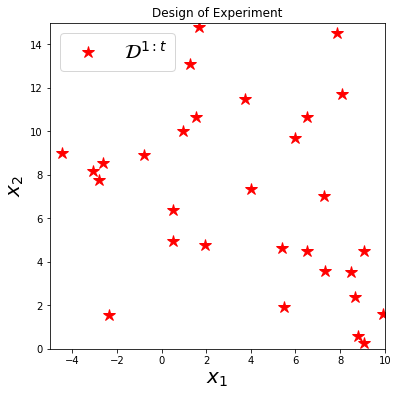

In [2]:
t = 30
d = 2
lb = np.reshape(np.array([-5.0, 0.0]),(-1,1))
ub = np.reshape(np.array([10.0, 15.0]),(-1,1))
X = np.reshape(np.random.rand(t,d),(-1,d))*(ub.T-lb.T) + lb.T
Y = np.reshape(f(X), (-1,1))
plt.plot(X[:,0], X[:,1], '*', markersize=12, color='red', label='$\mathcal{D}^{1:t}$')
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)
plt.title('Design of Experiment')
plt.xlim([-5,10])
plt.ylim([0,15])
plt.legend(fontsize=20)
plt.show()

For this problem we will normalize the input parameters, that is

In [3]:
X = (X - lb.T)/(ub.T - lb.T)

## Model Construction
    1. define the kernel
    2. fix the likelyhood variance $\epsilon$ 
    
$$y^{1:t}=f^{1:t}+\epsilon$$

where $\epsilon\sim\mathcal{N}(0,\nu)$ denotes measurement noise (i.e. the likelyhood variance in the gpflow notation)

in this case-study, we assume that $\epsilon \approx 0$ (i.e. it is very small, roughly on the order of 1e-6)

In [4]:
k = gpflow.kernels.RBF(d, ARD=True)
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 1e-6
m.kern.variance.trainable = True
m.likelihood.variance.trainable = False
print(m.read_trainables())

{'GPR/kern/lengthscales': array([ 1.,  1.]), 'GPR/kern/variance': array(1.0)}


plot the gp before optimizing the hyerparameters and show the hyperparameters

/home/jLinux/anaconda2/envs/python354/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


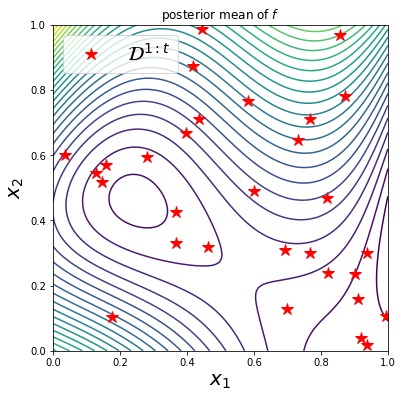

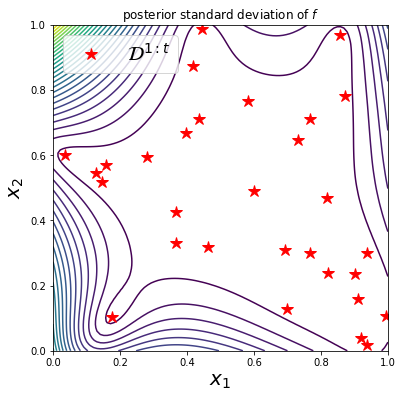

                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True  (2,)   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve      False    ()   

                         fixed_shape       value  
GPR/kern/lengthscales           True  [1.0, 1.0]  
GPR/kern/variance               True         1.0  
GPR/likelihood/variance         True       1e-06  


In [5]:
def plot(m):
    resolution = 100
    xx = np.linspace(0.0, 1.0, resolution).reshape(resolution, 1)
    mean = np.zeros((resolution, resolution))
    var = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            mean[j, i], var[j, i] = m.predict_y(np.reshape(np.array([xx[i], xx[j]]), (-1,d)))
    x1, x2 = np.meshgrid(xx,xx)
    
    # plot mean
    plt.plot(X[:,0], X[:,1], '*', markersize=12, color='red', label='$\mathcal{D}^{1:t}$')
    plt.contour(x1, x2, mean, 30, label='$\mu_f^{pos}$')
    plt.xlabel('$x_1$', fontsize=20)
    plt.ylabel('$x_2$', fontsize=20)
    plt.title('posterior mean of $f$')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(fontsize=20, loc=2)
    plt.show()
    
    # plot standard deviation
    plt.plot(X[:,0], X[:,1], '*', markersize=12, color='red', label='$\mathcal{D}^{1:t}$')
    plt.contour(x1, x2, np.sqrt(var), 30, label='$\sigma_f^{pos}$')
    plt.xlabel('$x_1$', fontsize=20)
    plt.ylabel('$x_2$', fontsize=20)
    plt.title('posterior standard deviation of $f$')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(fontsize=20, loc=2)
    plt.show()
    
plot(m)
print(m)

optimize the hyperparameters and replot the posterior gp

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 92.943069
  Number of iterations: 57
  Number of functions evaluations: 111


/home/jLinux/anaconda2/envs/python354/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


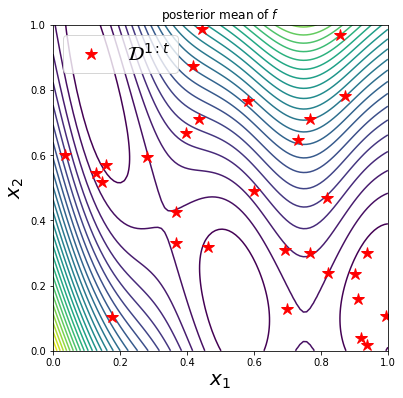

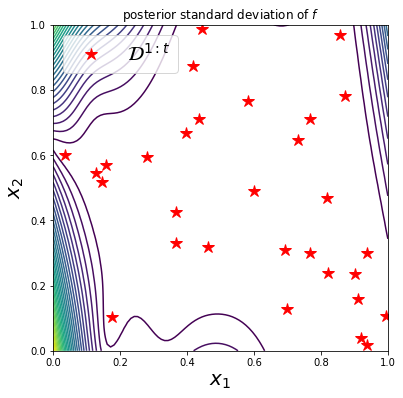

                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True  (2,)   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve      False    ()   

                         fixed_shape                            value  
GPR/kern/lengthscales           True  [0.293793055709, 1.44308844677]  
GPR/kern/variance               True               180388.39299754013  
GPR/likelihood/variance         True                            1e-06  


In [6]:
gpflow.train.ScipyOptimizer().minimize(m)
m.compile()
plot(m)
print(m)

Extract the hyperparameters from the model

In [7]:
print('variance    :', m.kern.variance.value)
print('lengthscales:', m.kern.lengthscales.value)

variance    : 180388.39299754013
lengthscales: [ 0.29379306  1.44308845]


Note:
1. we have set ARD=True thus we will have a different lengthscale for each dimension
2. the scale of each input parameter is set to $x\in[0,1]\times[0,1]$... going back to original dimensionality is trivial